- PostgreSQL은 재실행 로그 기반 복구를 구현.
- 데이터베이스 서버가 충돌하는 경우 PostgreSQL은 REDO 시점부터 WAL 세그먼트 파일의 XLOG 레코드를 순차적으로 재생하여 데이터베이스 클러스터를 복원할 수 있dma.

- 아직 설명되지 않은 회복에 관한 두 가지 사항에 대해 설명.
  - 첫 번째는 PostgreSQL이 복구 프로세스를 시작하는 방법.
  - PostgreSQL이 시작되면 먼저 pg_control 파일을 읽음.

**Details of the recovery process.**

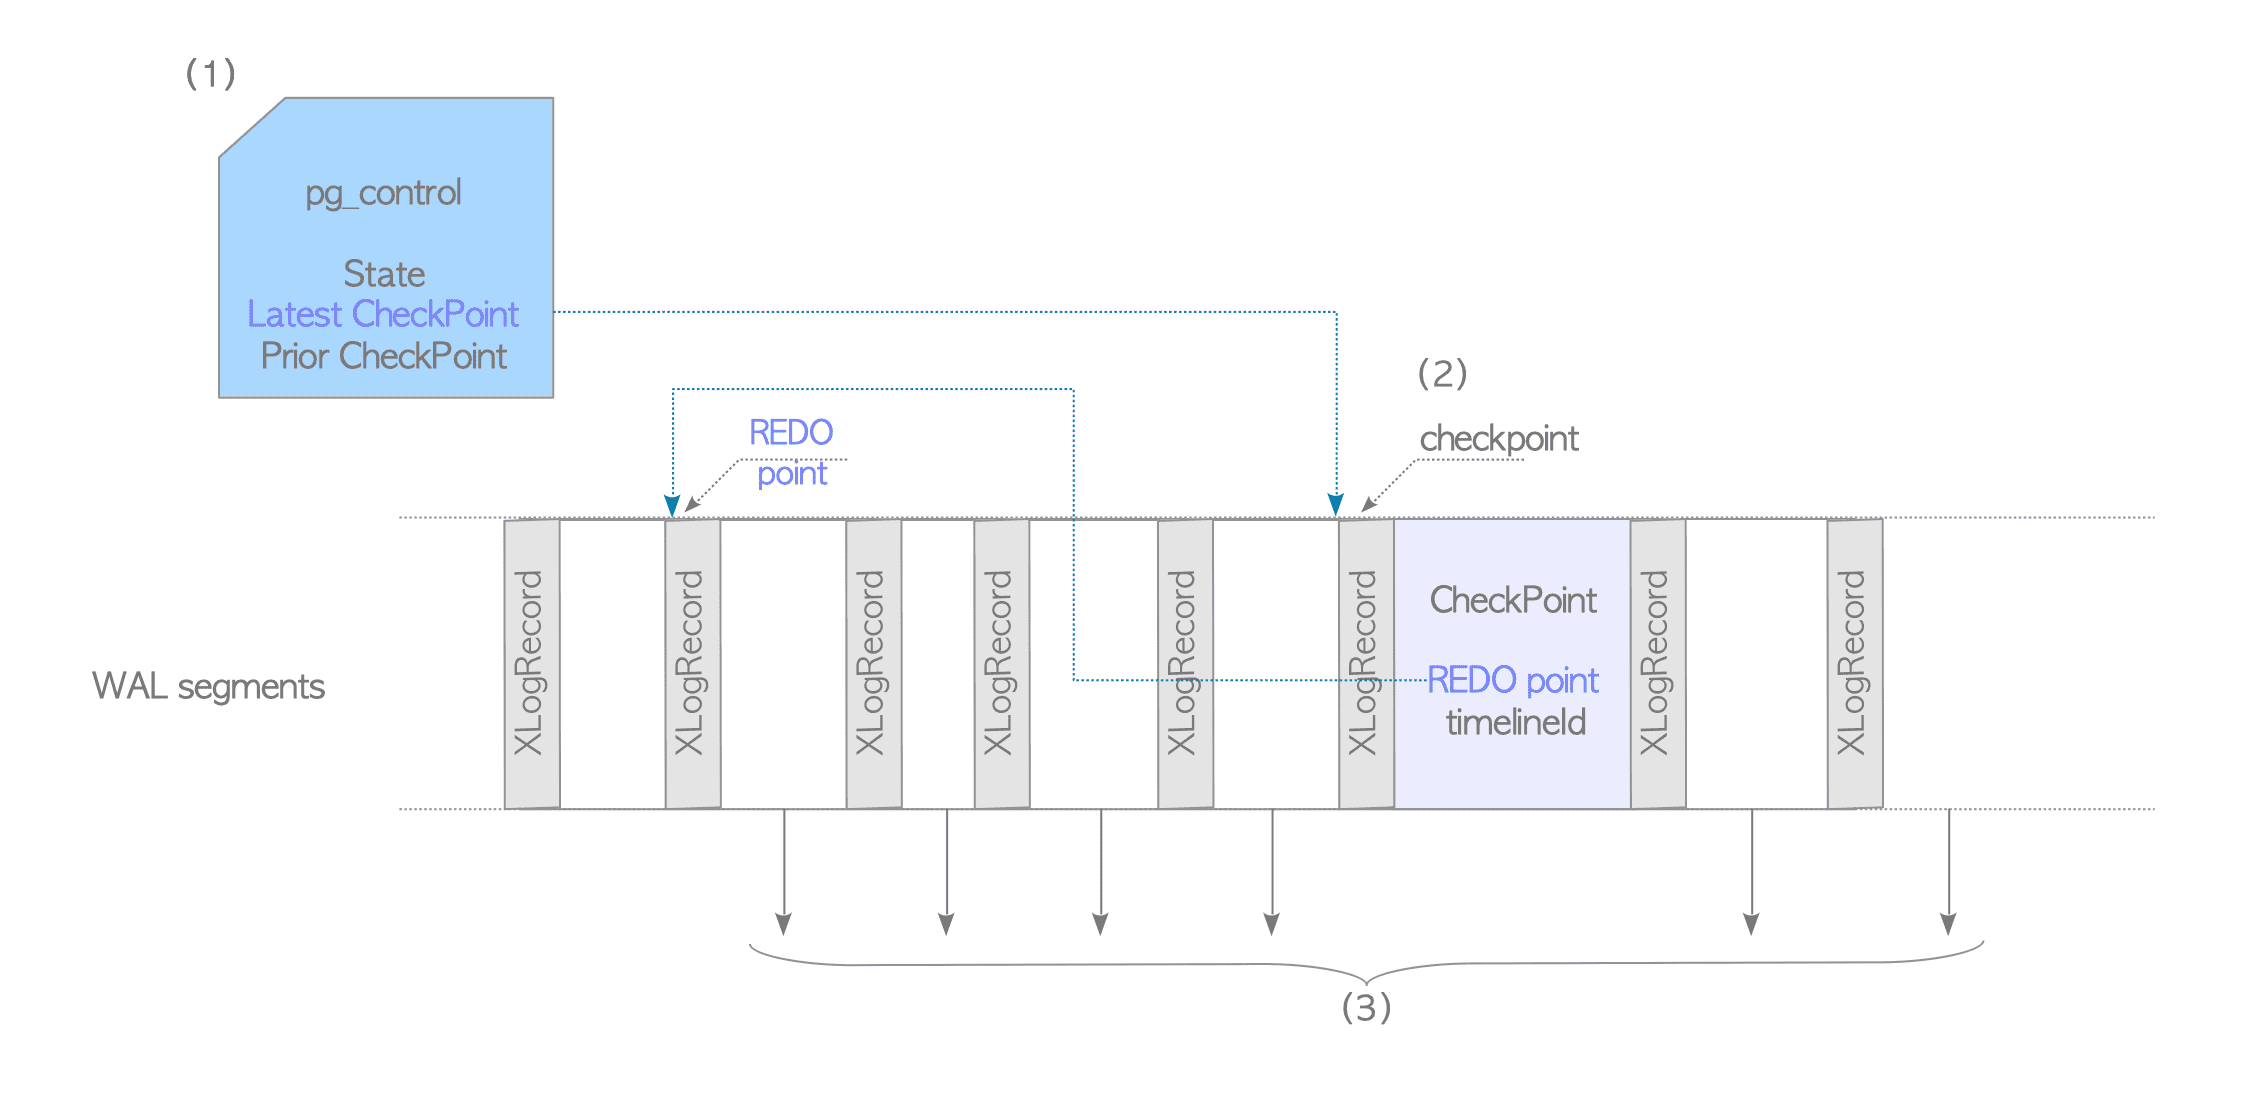

1. PostgreSQL은 시작될 때 pg_control 파일의 모든 항목을 읽음.
  - 상태 항목이 'in Production' 인 경우 PostgreSQL은 복구 모드로 진입.
  - 이는 데이터베이스가 정상적으로 종료되지 않았음을 의미하기 때문.
  - '종료'되면 PostgreSQL은 일반 시작 모드로 들어감.

2. PostgreSQL은 해당 WAL 세그먼트 파일에서 pg_control 파일에 위치가 기록된 최신 체크포인트 레코드를 읽음.
  - 그런 다음 레코드에서 REDO 지점을 가져옴.
  - 최신 체크포인트 레코드가 유효하지 않은 경우 PostgreSQL은 이전 체크포인트 레코드를 읽음.
  - 두 레코드를 모두 읽을 수 없으면 자체적으로 복구를 포기. (이전 체크포인트는 PostgreSQL 11 이상에는 저장되지 않음.)

3. 적절한 리소스 관리자는 REDO 지점부터 최신 WAL 세그먼트의 끝에 도달할 때까지 XLOG 레코드를 순차적으로 읽고 재생.
  - XLOG 레코드가 재생될 때 백업 블록인 경우 LSN과 상관없이 해당 테이블 페이지에 덮어쓰기됨.
  - 그렇지 않으면 (비백업 블록)XLOG 레코드는 해당 레코드의 LSN이 해당 페이지의 'pd_lsn'보다 큰 경우에만 재생.

<br>

- 두 번째 요점은 LSN 비교에 관한 것.
  - 즉, 비백업 블록의 LSN과 해당 페이지의 pd_lsn을 비교해야 하는 이유.
  - 이전 예와 달리 비교의 필요성을 강조하는 구체적인 예를 들어 설명.(설명을 단순화하기 위해 WAL 버퍼를 생략.)

**Insertion operations during the background writer working.**

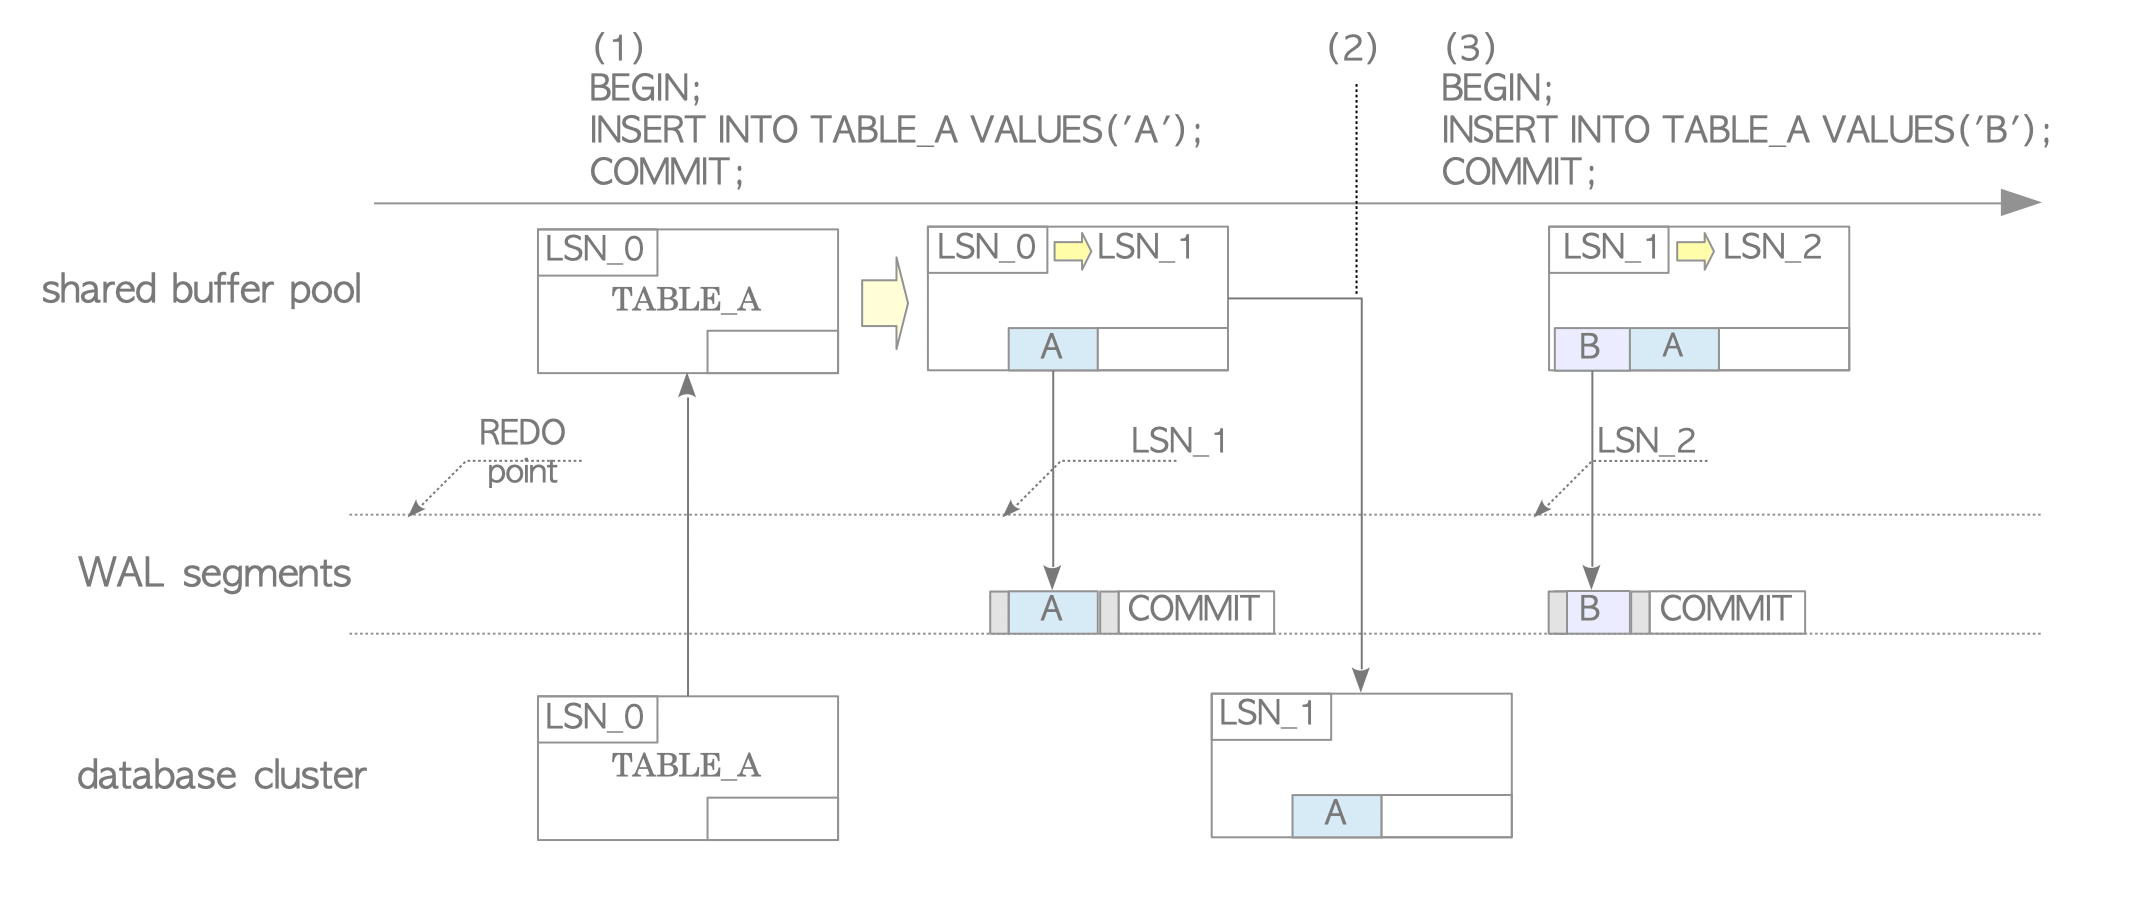

1. PostgreSQL은 TABLE_A에 튜플을 삽입하고 LSN_1에 XLOG 레코드를 씀.

2. 백그라운드 작성기 프로세스는 TABLE_A 페이지를 스토리지에 씀.
  - 현재 이 페이지의 pd_lsn은 LSN_1.

3. PostgreSQL은 TABLE_A에 새 튜플을 삽입하고 LSN_2에 XLOG 레코드를 씀.
  - 수정된 페이지는 아직 저장소에 기록되지 않았음.

- 개요의 예와 달리 이 시나리오에서는 TABLE_A의 페이지가 스토리지에 한 번 기록되었음.

- 즉시 모드로 종료한 후 데이터베이스를 시작.

**Database recovery.**

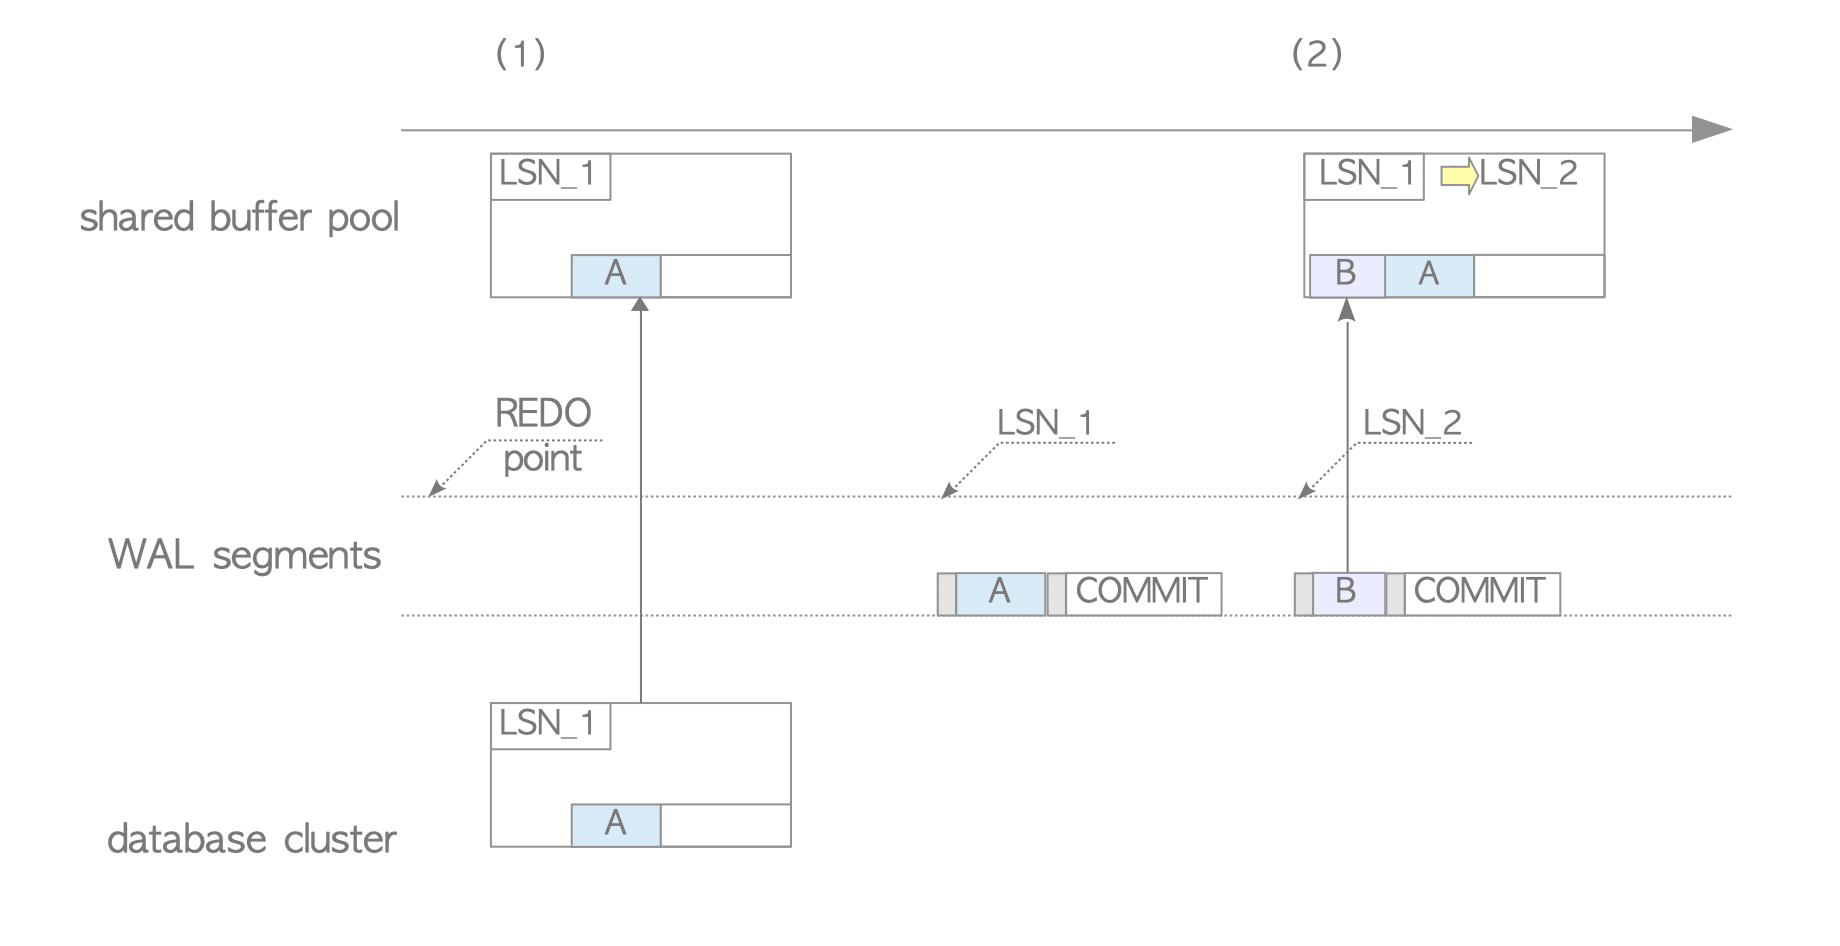

1. PostgreSQL은 첫 번째 XLOG 레코드와 TABLE_A 페이지를 로드하지만 레코드(LSN_1)의 LSN이 페이지의 LSN(또한 LSN_1)보다 크지 않기 때문에 이를 재생하지 않음.
  - 사실 다시 재생할 필요가 없다는 것이 분명.

2. 다음으로 PostgreSQL은 레코드(LSN_2)의 LSN이 TABLE_A 페이지의 현재 LSN(LSN_1)보다 크기 때문에 두 번째 XLOG 레코드를 재생.

<br>

- 이 예에서 볼 수 있듯이, 비백업 블록의 재생 순서가 올바르지 않거나 비백업 블록이 두 번 이상 재생되면 데이터베이스 클러스터는 더 이상 일관성을 갖지 않게 됨.
  - 즉, 백업되지 않은 블록의 redo(재생) 작업은 멱등성이 아님
  - 따라서 올바른 재생 순서를 유지하려면 LSN이 해당 페이지의 pd_lsn보다 큰 경우에만 비백업 블록 레코드를 재생해야 함.

- 반면, 백업 블록의 redo 작업은 멱등적이므로 LSN에 관계없이 백업 블록을 원하는 만큼 재생할 수 있음.